In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque
import random
import copy
from tqdm import tqdm

# Import SBEOS_Environment from the provided code
# (assuming the environment code is already imported)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims=[128, 64]):
        super(DQN, self).__init__()
        layers = []
        
        # Input layer
        layers.append(nn.Linear(input_dim, hidden_dims[0]))
        layers.append(nn.ReLU())
        
        # Hidden layers
        for i in range(len(hidden_dims)-1):
            layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
            layers.append(nn.ReLU())
        
        # Output layer
        layers.append(nn.Linear(hidden_dims[-1], output_dim))
        
        self.network = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.network(x)

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return np.array(states), np.array(actions), np.array(rewards), np.array(next_states), np.array(dones)
    
    def __len__(self):
        return len(self.buffer)

class DQNAgent:
    def __init__(self, state_dim, action_dim, lr=0.001, gamma=0.99, epsilon=1.0, 
                 epsilon_min=0.01, epsilon_decay=0.995, buffer_size=10000, batch_size=64,
                 update_target_freq=100):
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.batch_size = batch_size
        self.update_target_freq = update_target_freq
        self.buffer = ReplayBuffer(buffer_size)
        
        # Create Q networks
        self.q_network = DQN(state_dim, action_dim)
        self.target_network = copy.deepcopy(self.q_network)
        
        # Initialize optimizer
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=lr)
        
        # For tracking updates
        self.update_counter = 0
    
    def get_action(self, state, training=True):
        if training and np.random.rand() < self.epsilon:
            return np.random.randint(self.action_dim)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            with torch.no_grad():
                q_values = self.q_network(state_tensor)
            return torch.argmax(q_values).item()
    
    def train(self):
        if len(self.buffer) < self.batch_size:
            return 0
        
        # Sample batch from replay buffer
        states, actions, rewards, next_states, dones = self.buffer.sample(self.batch_size)
        
        # Convert to tensors
        states = torch.FloatTensor(states)
        actions = torch.LongTensor(actions)
        rewards = torch.FloatTensor(rewards)
        next_states = torch.FloatTensor(next_states)
        dones = torch.FloatTensor(dones)
        
        # Compute current Q values
        current_q = self.q_network(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        
        # Compute target Q values
        with torch.no_grad():
            next_q = self.target_network(next_states).max(1)[0]
            target_q = rewards + (1 - dones) * self.gamma * next_q
        
        # Compute loss and update
        loss = F.mse_loss(current_q, target_q)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        # Update target network periodically
        self.update_counter += 1
        if self.update_counter % self.update_target_freq == 0:
            self.target_network.load_state_dict(self.q_network.state_dict())
        
        # Decay epsilon
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
        
        return loss.item()
    
    def save_model(self, path):
        torch.save(self.q_network.state_dict(), path)
    
    def load_model(self, path):
        self.q_network.load_state_dict(torch.load(path))
        self.target_network.load_state_dict(self.q_network.state_dict())

def train_dqn(env, agent, num_episodes=1000, max_steps=None, eval_freq=10):
    """Train the DQN agent and return training history."""
    if max_steps is None:
        max_steps = env.max_timesteps
    
    # Metrics tracking
    episode_rewards = []
    episode_accuracies = []
    episode_energy_consumption = []
    eval_rewards = []
    eval_accuracies = []
    eval_energy_consumption = []
    
    for episode in tqdm(range(num_episodes)):
        state = env.reset()
        episode_reward = 0
        correct_predictions = 0
        total_predictions = 0
        energy_spent = 0
        
        for step in range(max_steps):
            # Select action
            action = agent.get_action(state)
            
            # Take action
            next_state, reward, done, info = env.step(action)
            
            # Store experience
            agent.buffer.add(state, action, reward, next_state, done)
            
            # Train agent
            agent.train()
            
            # Update metrics
            episode_reward += reward
            energy_cost = info["energy_cost"]
            energy_spent += energy_cost
            
            # Track prediction accuracy (based on returned reward)
            # Assuming reward > 0 means correct prediction
            if reward > 0:
                correct_predictions += 1
            total_predictions += 1
            
            # Move to next state
            state = next_state
            
            if done:
                break
        
        # Calculate episode accuracy
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        # Store episode metrics
        episode_rewards.append(episode_reward)
        episode_accuracies.append(episode_accuracy)
        episode_energy_consumption.append(energy_spent)
        
        # Periodic evaluation
        if (episode + 1) % eval_freq == 0:
            eval_reward, eval_accuracy, eval_energy = evaluate_agent(env, agent)
            eval_rewards.append(eval_reward)
            eval_accuracies.append(eval_accuracy)
            eval_energy_consumption.append(eval_energy)
            
            print(f"Episode {episode+1}/{num_episodes}")
            print(f"  Training: Reward={episode_reward:.2f}, Accuracy={episode_accuracy:.2f}, Energy={energy_spent:.2f}")
            print(f"  Evaluation: Reward={eval_reward:.2f}, Accuracy={eval_accuracy:.2f}, Energy={eval_energy:.2f}")
    
    # Final evaluation
    final_eval_reward, final_eval_accuracy, final_eval_energy = evaluate_agent(env, agent)
    
    # Return training history
    history = {
        "train_rewards": episode_rewards,
        "train_accuracies": episode_accuracies,
        "train_energy": episode_energy_consumption,
        "eval_rewards": eval_rewards,
        "eval_accuracies": eval_accuracies,
        "eval_energy": eval_energy_consumption,
        "final_eval_reward": final_eval_reward,
        "final_eval_accuracy": final_eval_accuracy,
        "final_eval_energy": final_eval_energy
    }
    
    return history

def evaluate_agent(env, agent, num_episodes=5):
    """Evaluate the agent without exploration."""
    total_rewards = []
    total_accuracies = []
    total_energy = []
    
    for _ in range(num_episodes):
        state = env.reset()
        episode_reward = 0
        correct_predictions = 0
        total_predictions = 0
        energy_spent = 0
        
        done = False
        while not done:
            action = agent.get_action(state, training=False)  # No exploration
            next_state, reward, done, info = env.step(action)
            
            episode_reward += reward
            energy_cost = info["energy_cost"]
            energy_spent += energy_cost
            
            if reward > 0:
                correct_predictions += 1
            total_predictions += 1
            
            state = next_state
        
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        total_rewards.append(episode_reward)
        total_accuracies.append(episode_accuracy)
        total_energy.append(energy_spent)
    
    return np.mean(total_rewards), np.mean(total_accuracies), np.mean(total_energy)

def plot_training_results(history, save_path=None):
    """Plot training and evaluation metrics."""
    fig, axs = plt.subplots(3, 1, figsize=(12, 15))
    
    # Plot rewards
    axs[0].plot(history["train_rewards"], label='Training')
    axs[0].plot(np.arange(0, len(history["train_rewards"]), len(history["train_rewards"])//len(history["eval_rewards"]))[:len(history["eval_rewards"])], 
                history["eval_rewards"], label='Evaluation')
    axs[0].set_title('Episode Rewards')
    axs[0].set_xlabel('Episode')
    axs[0].set_ylabel('Reward')
    axs[0].legend()
    axs[0].grid(True)
    
    # Plot accuracies
    axs[1].plot(history["train_accuracies"], label='Training')
    axs[1].plot(np.arange(0, len(history["train_accuracies"]), len(history["train_accuracies"])//len(history["eval_accuracies"]))[:len(history["eval_accuracies"])], 
                history["eval_accuracies"], label='Evaluation')
    axs[1].set_title('Prediction Accuracy')
    axs[1].set_xlabel('Episode')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()
    axs[1].grid(True)
    
    # Plot energy consumption
    axs[2].plot(history["train_energy"], label='Training')
    axs[2].plot(np.arange(0, len(history["train_energy"]), len(history["train_energy"])//len(history["eval_energy"]))[:len(history["eval_energy"])], 
                history["eval_energy"], label='Evaluation')
    axs[2].set_title('Energy Consumption')
    axs[2].set_xlabel('Episode')
    axs[2].set_ylabel('Energy')
    axs[2].legend()
    axs[2].grid(True)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path)
    
    plt.show()
    
    # Print final evaluation metrics
    print(f"Final Evaluation Metrics:")
    print(f"  Reward: {history['final_eval_reward']:.2f}")
    print(f"  Accuracy: {history['final_eval_accuracy']:.2f}")
    print(f"  Energy Consumption: {history['final_eval_energy']:.2f}")

Initializing SBEOS environment...
State dimension: 16, Action dimension: 4
Training DQN on SBEOS environment...


  4%|▍         | 20/500 [00:06<03:28,  2.30it/s]

Episode 20/500
  Training: Reward=1430.00, Accuracy=0.81, Energy=533.00
  Evaluation: Reward=1866.00, Accuracy=0.95, Energy=640.20


  8%|▊         | 40/500 [00:12<03:09,  2.43it/s]

Episode 40/500
  Training: Reward=1475.00, Accuracy=0.82, Energy=812.00
  Evaluation: Reward=1791.00, Accuracy=0.93, Energy=550.20


 12%|█▏        | 60/500 [00:18<02:58,  2.46it/s]

Episode 60/500
  Training: Reward=1595.00, Accuracy=0.86, Energy=821.00
  Evaluation: Reward=1659.00, Accuracy=0.88, Energy=534.00


 16%|█▌        | 80/500 [00:24<02:49,  2.48it/s]

Episode 80/500
  Training: Reward=1865.00, Accuracy=0.95, Energy=1028.00
  Evaluation: Reward=1773.00, Accuracy=0.92, Energy=661.80


 20%|██        | 100/500 [00:30<02:44,  2.43it/s]

Episode 100/500
  Training: Reward=1400.00, Accuracy=0.80, Energy=1145.00
  Evaluation: Reward=1728.00, Accuracy=0.91, Energy=1227.00


 24%|██▍       | 120/500 [00:36<02:33,  2.47it/s]

Episode 120/500
  Training: Reward=1910.00, Accuracy=0.97, Energy=992.00
  Evaluation: Reward=1728.00, Accuracy=0.91, Energy=1651.80


 28%|██▊       | 140/500 [00:43<02:29,  2.41it/s]

Episode 140/500
  Training: Reward=1685.00, Accuracy=0.90, Energy=1127.00
  Evaluation: Reward=1620.00, Accuracy=0.87, Energy=1709.40


 32%|███▏      | 160/500 [00:49<02:19,  2.44it/s]

Episode 160/500
  Training: Reward=1805.00, Accuracy=0.94, Energy=776.00
  Evaluation: Reward=1833.00, Accuracy=0.94, Energy=1594.20


 36%|███▌      | 180/500 [00:55<02:11,  2.43it/s]

Episode 180/500
  Training: Reward=1265.00, Accuracy=0.76, Energy=1028.00
  Evaluation: Reward=1839.00, Accuracy=0.94, Energy=881.40


 40%|████      | 200/500 [01:01<02:02,  2.45it/s]

Episode 200/500
  Training: Reward=1475.00, Accuracy=0.82, Energy=1280.00
  Evaluation: Reward=1704.00, Accuracy=0.90, Energy=1036.20


 44%|████▍     | 220/500 [01:07<01:54,  2.44it/s]

Episode 220/500
  Training: Reward=1820.00, Accuracy=0.94, Energy=1109.00
  Evaluation: Reward=1728.00, Accuracy=0.91, Energy=215.40


 48%|████▊     | 240/500 [01:13<01:46,  2.45it/s]

Episode 240/500
  Training: Reward=1310.00, Accuracy=0.77, Energy=1028.00
  Evaluation: Reward=1686.00, Accuracy=0.89, Energy=273.00


 52%|█████▏    | 260/500 [01:19<01:37,  2.46it/s]

Episode 260/500
  Training: Reward=1910.00, Accuracy=0.97, Energy=1199.00
  Evaluation: Reward=1560.00, Accuracy=0.85, Energy=895.80


 56%|█████▌    | 280/500 [01:25<01:29,  2.45it/s]

Episode 280/500
  Training: Reward=1205.00, Accuracy=0.73, Energy=1172.00
  Evaluation: Reward=1773.00, Accuracy=0.92, Energy=1158.60


 60%|██████    | 300/500 [01:31<01:21,  2.46it/s]

Episode 300/500
  Training: Reward=1805.00, Accuracy=0.94, Energy=1118.00
  Evaluation: Reward=1641.00, Accuracy=0.88, Energy=899.40


 64%|██████▍   | 320/500 [01:37<01:13,  2.45it/s]

Episode 320/500
  Training: Reward=1355.00, Accuracy=0.79, Energy=1136.00
  Evaluation: Reward=1809.00, Accuracy=0.93, Energy=771.60


 68%|██████▊   | 340/500 [01:44<01:07,  2.37it/s]

Episode 340/500
  Training: Reward=1505.00, Accuracy=0.83, Energy=1253.00
  Evaluation: Reward=1713.00, Accuracy=0.90, Energy=796.80


 72%|███████▏  | 360/500 [01:50<00:57,  2.44it/s]

Episode 360/500
  Training: Reward=1490.00, Accuracy=0.83, Energy=1181.00
  Evaluation: Reward=1812.00, Accuracy=0.93, Energy=854.40


 76%|███████▌  | 380/500 [01:56<00:49,  2.45it/s]

Episode 380/500
  Training: Reward=1535.00, Accuracy=0.84, Energy=1289.00
  Evaluation: Reward=1653.00, Accuracy=0.88, Energy=1547.40


 80%|████████  | 400/500 [02:02<00:41,  2.43it/s]

Episode 400/500
  Training: Reward=1850.00, Accuracy=0.95, Energy=1082.00
  Evaluation: Reward=1737.00, Accuracy=0.91, Energy=1659.00


 84%|████████▍ | 420/500 [02:08<00:33,  2.42it/s]

Episode 420/500
  Training: Reward=1730.00, Accuracy=0.91, Energy=1091.00
  Evaluation: Reward=1722.00, Accuracy=0.90, Energy=1045.20


 88%|████████▊ | 440/500 [02:14<00:24,  2.42it/s]

Episode 440/500
  Training: Reward=1745.00, Accuracy=0.92, Energy=1208.00
  Evaluation: Reward=1704.00, Accuracy=0.90, Energy=744.60


 92%|█████████▏| 460/500 [02:20<00:16,  2.44it/s]

Episode 460/500
  Training: Reward=1340.00, Accuracy=0.78, Energy=1181.00
  Evaluation: Reward=1710.00, Accuracy=0.90, Energy=262.20


 96%|█████████▌| 480/500 [02:26<00:08,  2.44it/s]

Episode 480/500
  Training: Reward=1340.00, Accuracy=0.78, Energy=1181.00
  Evaluation: Reward=1722.00, Accuracy=0.90, Energy=1623.00


100%|██████████| 500/500 [02:33<00:00,  3.27it/s]

Episode 500/500
  Training: Reward=1850.00, Accuracy=0.95, Energy=1064.00
  Evaluation: Reward=1710.00, Accuracy=0.90, Energy=1783.20


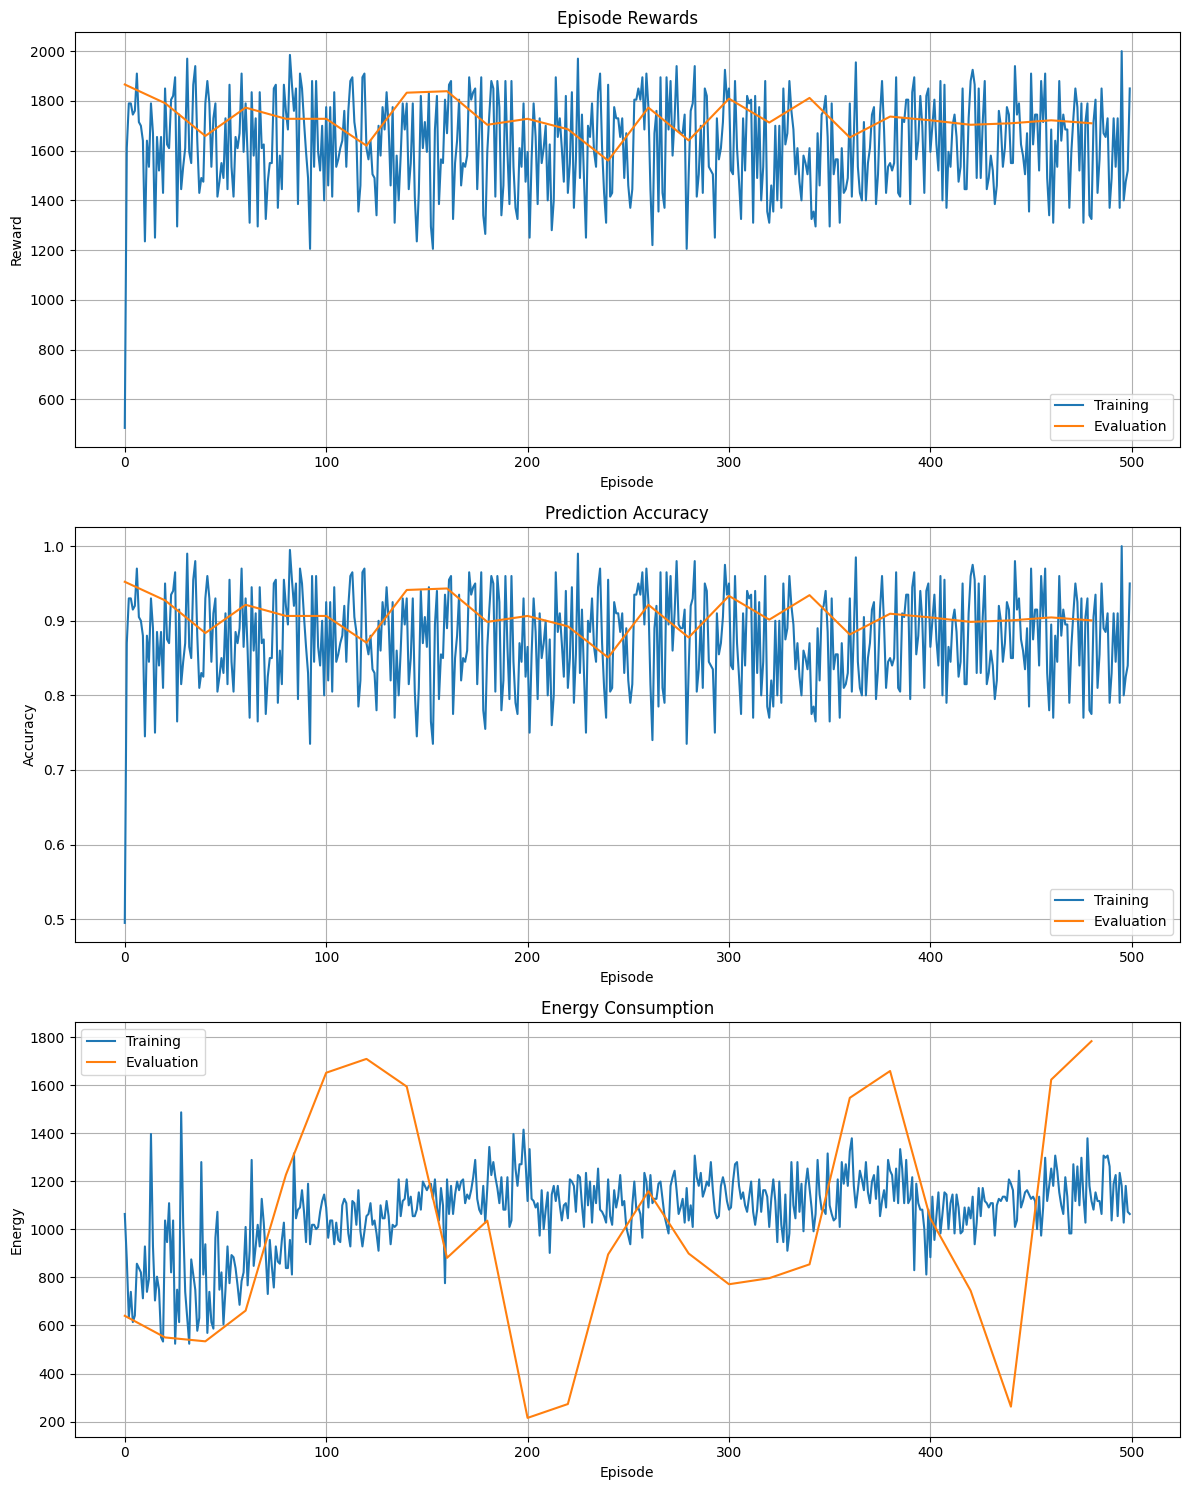

Final Evaluation Metrics:
  Reward: 1545.00
  Accuracy: 0.85
  Energy Consumption: 1803.00
Training completed and model saved.
Performing final evaluation...

Evaluation Results:
Average Reward: 1747.50 ± 156.64
Average Accuracy: 0.91 ± 0.05
Average Energy Consumption: 1767.90 ± 51.46


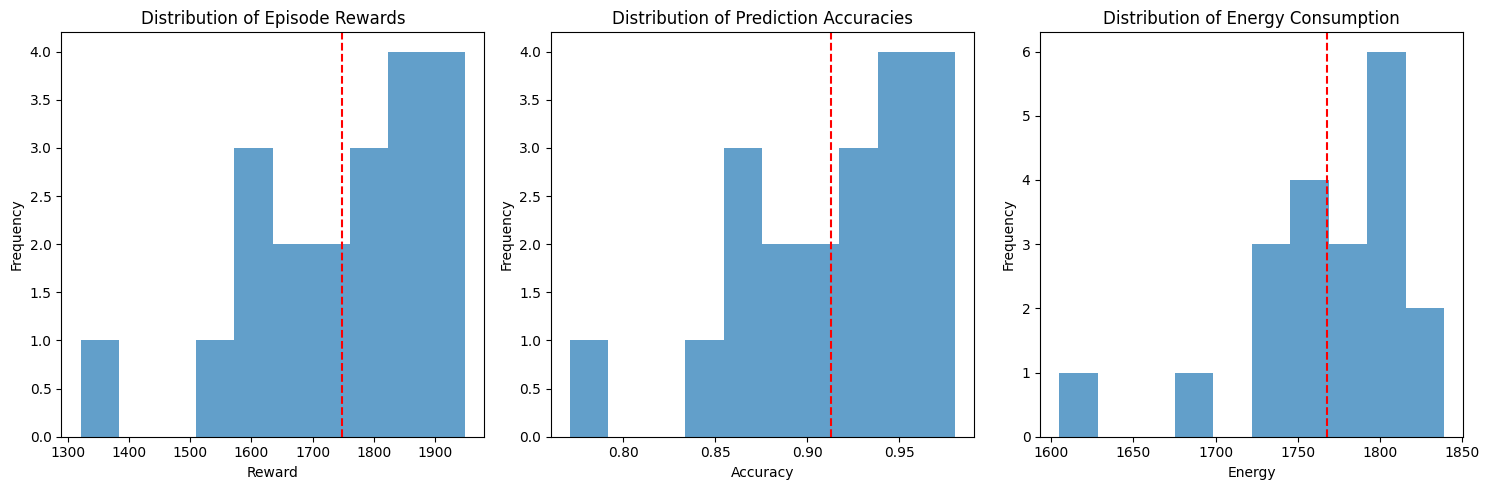

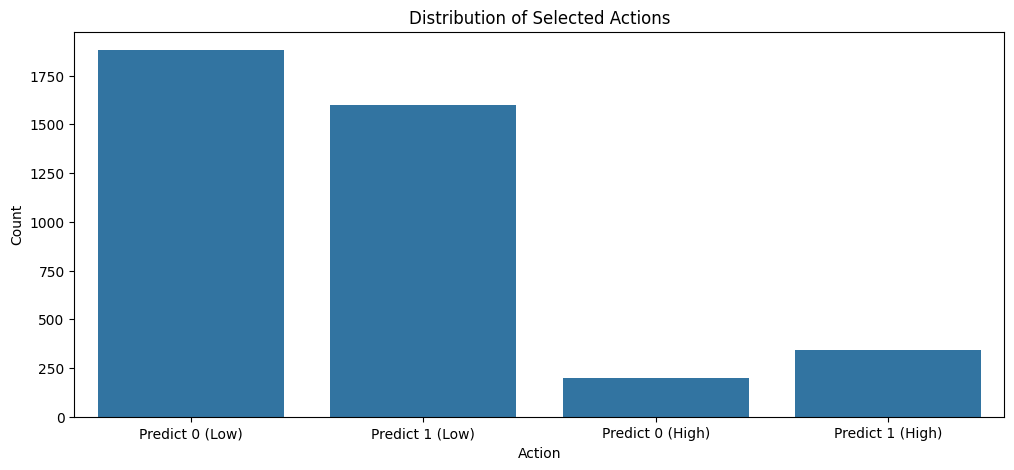

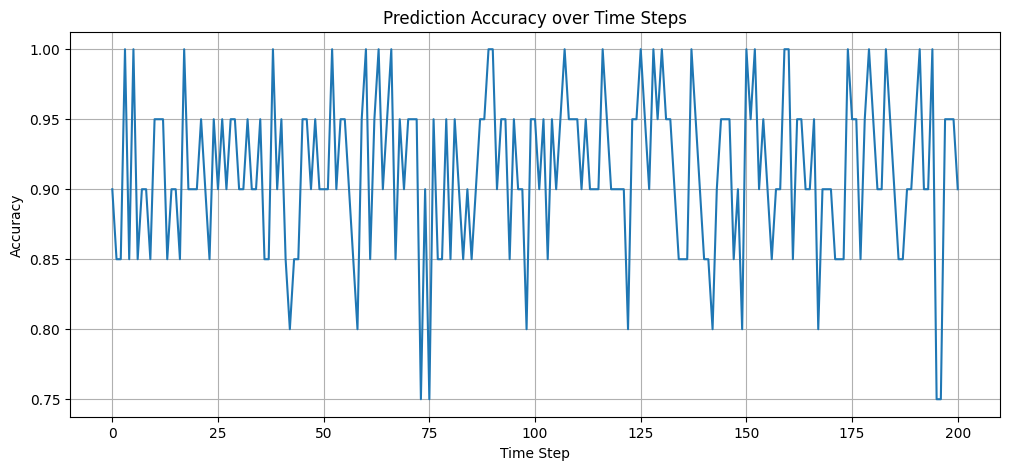

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import pandas as pd
import seaborn as sns

# Import environment and DQN implementation
# (assuming they're already imported)
from environments import SBEOS_Environment, MultiBandSBEOS

# Import DQN implementation from previous code
# In a real script, you would import these from a module
# from dqn_implementation import DQNAgent, train_dqn, evaluate_agent, plot_training_results

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
random.seed(42)

def train_and_evaluate_sbeos():
    """Train and evaluate DQN on the SBEOS environment"""
    print("Initializing SBEOS environment...")
    
    # Initialize environment
    env = SBEOS_Environment(
        max_timesteps=200,
        energy_cost=10,
        reward=10,
        penalty=5,
        pressure=0.1,
        window_size=10,
        time_dependence=4
    )
    
    # Reset environment to get state dimensions
    initial_state = env.reset()
    state_dim = len(initial_state)
    action_dim = 4  # 4 possible actions in SBEOS (0, 1 with low/high energy)
    
    print(f"State dimension: {state_dim}, Action dimension: {action_dim}")
    
    # Initialize DQN agent
    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=0.001,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.05,
        epsilon_decay=0.995,
        buffer_size=10000,
        batch_size=64,
        update_target_freq=200
    )
    
    # Train the agent
    print("Training DQN on SBEOS environment...")
    history = train_dqn(env, agent, num_episodes=500, eval_freq=20)
    
    # Plot training results
    plot_training_results(history)
    
    # Save the trained model
    agent.save_model("dqn_sbeos_model.pth")
    print("Training completed and model saved.")
    
    # Comprehensive evaluation
    print("Performing final evaluation...")
    test_env = SBEOS_Environment(
        max_timesteps=200,
        energy_cost=10,
        reward=10,
        penalty=5,
        pressure=0.1,
        window_size=10,
        time_dependence=4
    )
    
    # Evaluate with multiple episodes
    eval_episodes = 20
    rewards = []
    accuracies = []
    energy_consumption = []
    episode_data = []
    
    for episode in range(eval_episodes):
        state = test_env.reset()
        episode_reward = 0
        correct_predictions = 0
        total_predictions = 0
        energy_spent = 0
        step_data = []
        
        done = False
        step = 0
        
        while not done:
            # Get action from trained agent (no exploration)
            action = agent.get_action(state, training=False)
            
            # Take action in environment
            next_state, reward, done, info = test_env.step(action)
            
            # Update metrics
            episode_reward += reward
            energy_cost = info["energy_cost"]
            energy_spent += energy_cost
            
            # Track prediction accuracy
            is_correct = reward > 0
            if is_correct:
                correct_predictions += 1
            total_predictions += 1
            
            # Store step data
            step_data.append({
                "episode": episode,
                "step": step,
                "action": action,
                "reward": reward,
                "energy_cost": energy_cost,
                "correct_prediction": is_correct,
                "actual_state": info["state"]
            })
            
            # Move to next state
            state = next_state
            step += 1
        
        # Calculate episode accuracy
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        # Store episode metrics
        rewards.append(episode_reward)
        accuracies.append(episode_accuracy)
        energy_consumption.append(energy_spent)
        episode_data.extend(step_data)
    
    # Create DataFrame for detailed analysis
    df = pd.DataFrame(episode_data)
    
    # Print evaluation summary
    print("\nEvaluation Results:")
    print(f"Average Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Average Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}")
    print(f"Average Energy Consumption: {np.mean(energy_consumption):.2f} ± {np.std(energy_consumption):.2f}")
    
    # Additional visualizations
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(rewards, bins=10, alpha=0.7)
    plt.axvline(np.mean(rewards), color='r', linestyle='--')
    plt.title('Distribution of Episode Rewards')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(accuracies, bins=10, alpha=0.7)
    plt.axvline(np.mean(accuracies), color='r', linestyle='--')
    plt.title('Distribution of Prediction Accuracies')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(energy_consumption, bins=10, alpha=0.7)
    plt.axvline(np.mean(energy_consumption), color='r', linestyle='--')
    plt.title('Distribution of Energy Consumption')
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Action distribution analysis
    plt.figure(figsize=(12, 5))
    sns.countplot(x='action', data=df)
    plt.title('Distribution of Selected Actions')
    plt.xlabel('Action')
    plt.ylabel('Count')
    plt.xticks([0, 1, 2, 3], ['Predict 0 (Low)', 'Predict 1 (Low)', 'Predict 0 (High)', 'Predict 1 (High)'])
    plt.show()
    
    # Accuracy over time
    plt.figure(figsize=(12, 5))
    df_grouped = df.groupby('step')['correct_prediction'].mean().reset_index()
    plt.plot(df_grouped['step'], df_grouped['correct_prediction'])
    plt.title('Prediction Accuracy over Time Steps')
    plt.xlabel('Time Step')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.show()
    
    return agent, history, df

def train_and_evaluate_multiband_sbeos():
    """Train and evaluate DQN on the MultiBandSBEOS environment"""
    print("Initializing MultiBandSBEOS environment...")
    
    # Number of bands
    num_bands = 3
    
    # Initialize environment
    env = MultiBandSBEOS(
        num_bands=num_bands,
        max_timesteps=200,
        energy_cost=10,
        reward=10,
        penalty=5,
        pressure=0.1,
        window_size=10,
        time_dependence=4
    )
    
    # Reset environment to get state dimensions
    initial_state = env.reset()
    state_dim = len(initial_state)
    action_dim = 4 * num_bands  # 4 possible actions per band
    
    print(f"State dimension: {state_dim}, Action dimension: {action_dim}")
    
    # Initialize DQN agent
    agent = DQNAgent(
        state_dim=state_dim,
        action_dim=action_dim,
        lr=0.001,
        gamma=0.99,
        epsilon=1.0,
        epsilon_min=0.05,
        epsilon_decay=0.997,  # Slower decay for more complex environment
        buffer_size=20000,
        batch_size=128,
        update_target_freq=300
    )
    
    # Train the agent
    print("Training DQN on MultiBandSBEOS environment...")
    history = train_dqn(env, agent, num_episodes=800, eval_freq=40)
    
    # Plot training results
    plot_training_results(history)
    
    # Save the trained model
    agent.save_model("dqn_multiband_sbeos_model.pth")
    print("Training completed and model saved.")
    
    # Comprehensive evaluation
    print("Performing final evaluation...")
    test_env = MultiBandSBEOS(
        num_bands=num_bands,
        max_timesteps=200,
        energy_cost=10,
        reward=10,
        penalty=5,
        pressure=0.1,
        window_size=10,
        time_dependence=4
    )
    
    # Evaluate with multiple episodes
    eval_episodes = 20
    rewards = []
    accuracies = []
    energy_consumption = []
    episode_data = []
    
    for episode in range(eval_episodes):
        state = test_env.reset()
        episode_reward = 0
        correct_predictions = 0
        total_predictions = 0
        energy_spent = 0
        step_data = []
        
        done = False
        step = 0
        
        while not done:
            # Get action from trained agent (no exploration)
            action = agent.get_action(state, training=False)
            
            # Take action in environment
            next_state, reward, done, info = test_env.step(action)
            
            # Update metrics
            episode_reward += reward
            energy_cost = info["energy_cost"]
            transition_cost = info.get("transition_cost", 0)
            energy_spent += energy_cost + transition_cost
            
            # Track prediction accuracy
            is_correct = reward > 0
            if is_correct:
                correct_predictions += 1
            total_predictions += 1
            
            # Store step data
            step_data.append({
                "episode": episode,
                "step": step,
                "action": action,
                "selected_band": info.get("selected_band", action // 4),
                "reward": reward,
                "energy_cost": energy_cost,
                "transition_cost": transition_cost,
                "correct_prediction": is_correct,
                "actual_state": info.get("actual_state", None)
            })
            
            # Move to next state
            state = next_state
            step += 1
        
        # Calculate episode accuracy
        episode_accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        
        # Store episode metrics
        rewards.append(episode_reward)
        accuracies.append(episode_accuracy)
        energy_consumption.append(energy_spent)
        episode_data.extend(step_data)
    
    # Create DataFrame for detailed analysis
    df = pd.DataFrame(episode_data)
    
    # Print evaluation summary
    print("\nEvaluation Results:")
    print(f"Average Reward: {np.mean(rewards):.2f} ± {np.std(rewards):.2f}")
    print(f"Average Accuracy: {np.mean(accuracies):.2f} ± {np.std(accuracies):.2f}")
    print(f"Average Energy Consumption: {np.mean(energy_consumption):.2f} ± {np.std(energy_consumption):.2f}")
    
    # Additional visualizations
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.hist(rewards, bins=10, alpha=0.7)
    plt.axvline(np.mean(rewards), color='r', linestyle='--')
    plt.title('Distribution of Episode Rewards')
    plt.xlabel('Reward')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 2)
    plt.hist(accuracies, bins=10, alpha=0.7)
    plt.axvline(np.mean(accuracies), color='r', linestyle='--')
    plt.title('Distribution of Prediction Accuracies')
    plt.xlabel('Accuracy')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 3, 3)
    plt.hist(energy_consumption, bins=10, alpha=0.7)
    plt.axvline(np.mean(energy_consumption), color='r', linestyle='--')
    plt.title('Distribution of Energy Consumption')
    plt.xlabel('Energy')
    plt.ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    # Band selection analysis
    plt.figure(figsize=(10, 5))
    sns.countplot(x='selected_band', data=df)
    plt.title('Distribution of Selected Bands')
    plt.xlabel('Band')
    plt.ylabel('Count')
    plt.show()
    
    # Energy cost breakdown
    plt.figure(figsize=(12, 5))
    df_grouped = df.groupby('episode').agg({
        'energy_cost': 'sum',
        'transition_cost': 'sum'
    }).reset_index()
    
    plt.bar(df_grouped['episode'], df_grouped['energy_cost'], label='Action Energy')
    plt.bar(df_grouped['episode'], df_grouped['transition_cost'], bottom=df_grouped['energy_cost'], label='Transition Energy')
    plt.title('Energy Cost Breakdown by Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Energy')
    plt.legend()
    plt.show()
    
    return agent, history, df

if __name__ == "__main__":
    # Run training for single-band SBEOS
    agent_sbeos, history_sbeos, df_sbeos = train_and_evaluate_sbeos()
    
    # Run training for multi-band SBEOS (uncomment to run)
    # agent_multiband, history_multiband, df_multiband = train_and_evaluate_multiband_sbeos()